In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
from sklearn.datasets import load_iris
from ml_tooling import Model
from ml_tooling.data import Dataset
from ml_tooling.baseclass import logger
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
class IrisData(Dataset):
    def load_training_data(self):
        data = load_iris()
        return pd.DataFrame(data=data.data, columns=data.feature_names), np.where(data.target == 1, 1, 0)
    
    def load_prediction_data(self, idx):
        X, y = self.load_training_data()
        
        return X.loc[idx, :].to_frame().T
    
data = IrisData()
data.create_train_test()

<IrisData - Dataset>

In [3]:
rf_clf = Model(RandomForestClassifier(n_estimators=10))

In [4]:
lr = Model(LogisticRegression())

In [5]:
lr.score_estimator(data)

[13:21:03] - Scoring estimator...
/home/valentin/git/ml_tooling/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Result LogisticRegression: {'accuracy': 0.74}>

In [6]:
rf_clf.config.RANDOM_STATE = 42

In [7]:
rf_clf.config

<Config: 
VERBOSITY: 0
CLASSIFIER_METRIC: accuracy
REGRESSION_METRIC: r2
CROSS_VALIDATION: 10
STYLE_SHEET: /home/valentin/git/ml_tooling/src/ml_tooling/almbrand.mplstyle
N_JOBS: -1
RANDOM_STATE: 42
RUN_DIR: /home/valentin/git/ml_tooling/notebooks/runs
ESTIMATOR_DIR: /home/valentin/git/ml_tooling/notebooks/models
LOG: False
>

In [12]:
result = rf_clf.score_estimator(data, metrics='roc_auc', cv=10)

[13:24:31] - Scoring estimator...
[13:24:31] - Cross-validating...


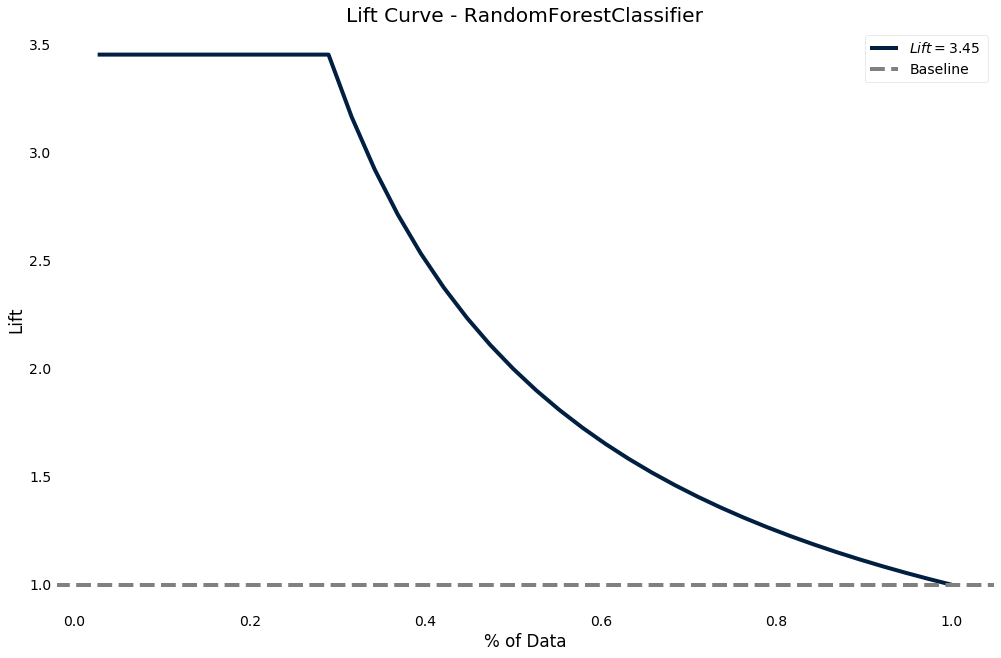

In [13]:
result.plot.lift_curve()

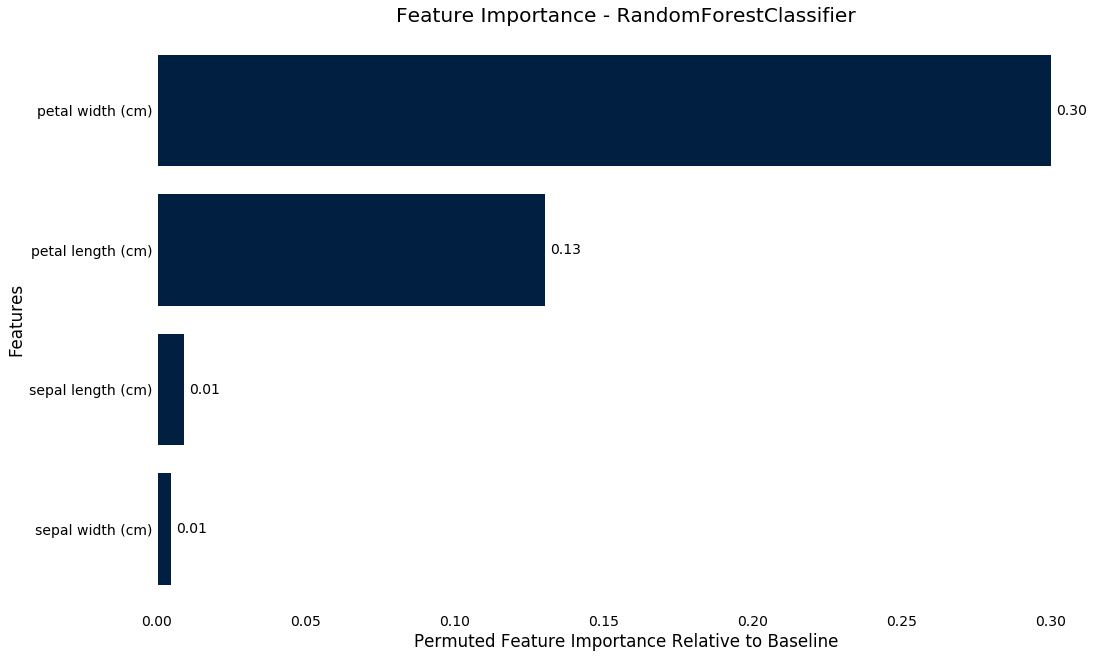

In [14]:
ax = result.plot.feature_importance(100)

In [15]:
with rf_clf.log('./gridsearch'):
    best_model, results = rf_clf.gridsearch(data, {"max_depth": [5, 10, 15]})

[13:24:42] - Starting gridsearch...
[13:24:43] - Done!
[13:24:43] - Saved run info at None


In [16]:
best_model

<Model: RandomForestClassifier>

In [19]:
results

ResultGroup(results=[<Result RandomForestClassifier: {'accuracy': 0.94}>, <Result RandomForestClassifier: {'accuracy': 0.94}>, <Result RandomForestClassifier: {'accuracy': 0.94}>])

In [29]:
with rf_clf.log('./test'):
    rf_clf.score_estimator(data)

[13:33:59] - Scoring estimator...
[13:33:59] - Saved run info at /home/valentin/git/ml_tooling/notebooks/runs/test/IrisData_RandomForestClassifier_133359_0.yaml


In [30]:
from ml_tooling.storage import FileStorage

storage = FileStorage('./save')
with rf_clf.log('./save'):
    estimator_path = rf_clf.save_estimator(storage)

[13:33:59] - Saved estimator to save/RandomForestClassifier_2019-10-22_13:33:59.919305.pkl


In [31]:
test_clf = Model.load_estimator(storage, estimator_path.name)

[13:34:43] - Loaded RandomForestClassifier


In [32]:
test_clf.estimator

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [33]:
test_clf.make_prediction(data, 19, proba=True)

,0,1
0,1.0,0.0


In [34]:
from sklearn.dummy import DummyClassifier

In [37]:
best_model, results = Model.test_estimators(data, [RandomForestClassifier(n_estimators=10), LogisticRegression(), DummyClassifier()], log_dir='')

[13:36:52] - Training estimator 1/3: RandomForestClassifier
[13:36:52] - Scoring estimator...
[13:36:52] - Training estimator 2/3: LogisticRegression
[13:36:52] - Scoring estimator...
/home/valentin/git/ml_tooling/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[13:36:52] - Training estimator 3/3: DummyClassifier
[13:36:52] - Scoring estimator...
[13:36:52] - Best estimator: RandomForestClassifier - accuracy: 1.0


In [38]:
results

ResultGroup(results=[<Result RandomForestClassifier: {'accuracy': 1.0}>, <Result LogisticRegression: {'accuracy': 0.74}>, <Result DummyClassifier: {'accuracy': 0.5}>])